2025-02-03 21:09:40,863 - INFO - Data loaded successfully.
2025-02-03 21:09:40,904 - INFO - Data cleaning and type conversion complete.
2025-02-03 21:09:40,913 - INFO - Feature engineering setup complete.


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

2025-02-03 21:09:56,352 - INFO - Model training complete.


              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.59      0.54      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409

AUC: 0.8185706166524581


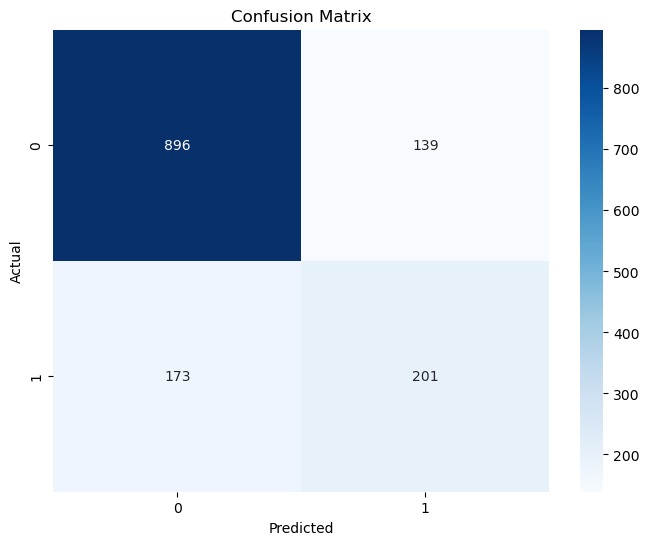

2025-02-03 21:09:56,770 - INFO - Model evaluation complete.
2025-02-03 21:09:56,804 - INFO - Feature importance analysis complete.



Top 10 Feature Importances:
                             Feature  Importance
3                       TotalCharges    0.067981
1                             tenure    0.064844
2                     MonthlyCharges    0.054968
5670         Contract_Month-to-month    0.043327
5652               OnlineSecurity_No    0.029297
5677  PaymentMethod_Electronic check    0.027999
5661                  TechSupport_No    0.027480
5672               Contract_Two year    0.024892
5654              OnlineSecurity_Yes    0.019872
5658             DeviceProtection_No    0.018690


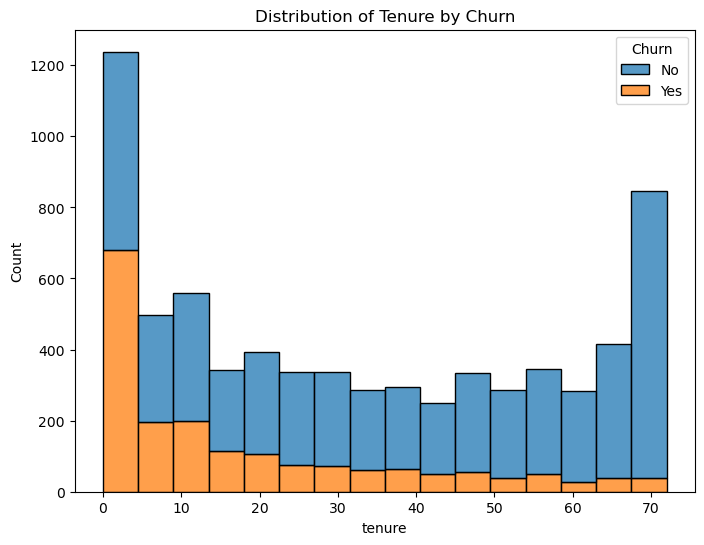

2025-02-03 21:09:57,150 - INFO - Visualization complete.
2025-02-03 21:09:57,151 - INFO - Program finished.


In [4]:
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Import SMOTE after installing imblearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def run_customer_churn_prediction(file_path):
    """
    Executes the customer churn prediction project with comprehensive error handling and logging.

    Args:
        file_path (str): Path to the CSV file containing the customer data.

    Returns:
        None
    """

    # Configure logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # 1. Data Collection and Exploration
    try:
        df = pd.read_csv(file_path)
        logging.info("Data loaded successfully.")

        # Basic EDA
        print(df.head())
        print(df.info())
        print(df.describe())

    except FileNotFoundError:
        logging.error(f"Error: File not found at {file_path}. Please ensure the file is in the correct directory.")
        return
    except pd.errors.ParserError:
        logging.error("Error: Could not parse the CSV file. Check the file format.")
        return
    except Exception as e:
        logging.exception(f"An unexpected error occurred during data loading: {e}")
        return

    # Data Cleaning and Preprocessing
    try:
        # Convert TotalCharges to numeric, handling errors
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        # Replace empty strings in 'TotalCharges' with NaN 
        df['TotalCharges'] = df['TotalCharges'].replace('', np.nan) 

        # Convert 'SeniorCitizen' to numeric (0 or 1)
        df['SeniorCitizen'] = pd.to_numeric(df['SeniorCitizen'])

        logging.info("Data cleaning and type conversion complete.")
    except Exception as e:
        logging.exception(f"An error occurred during data cleaning: {e}")
        return

    # 2. Feature Engineering
    try:
        # Separate features and target
        X = df.drop('Churn', axis=1)
        y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)  # Binary target

        # Define categorical and numerical features
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        if 'customerID' in numerical_features:
            numerical_features.remove('customerID')  # Remove ID from numerical features

        # Create preprocessor
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        logging.info("Feature engineering setup complete.")

    except Exception as e:
        logging.exception(f"An error occurred during feature engineering: {e}")
        return

    # 3. Model Building
    try:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Apply preprocessing
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)

        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Train Random Forest model
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_resampled, y_train_resampled)
        logging.info("Model training complete.")

    except Exception as e:
        logging.exception(f"An error occurred during model building: {e}")
        return

    # 4. Evaluation

    try:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        print(classification_report(y_test, y_pred))
        print("AUC:", roc_auc_score(y_test, y_prob))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        logging.info("Model evaluation complete.")
    except Exception as e:
        logging.exception(f"An error occurred during model evaluation: {e}")
        return

    # 5. Interpretation (Feature Importance)
    try:
        ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=categorical_features)
        all_feature_names = numerical_features + list(ohe_feature_names)

        feature_importances_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': model.feature_importances_})
        feature_importances_df_sorted = feature_importances_df.sort_values(by='Importance', ascending=False)
        print("\nTop 10 Feature Importances:")
        print(feature_importances_df_sorted.head(10))

        logging.info("Feature importance analysis complete.")
    except Exception as e:
        logging.exception(f"An error occurred during feature importance analysis: {e}")
        return

    # Visualization (Distribution of Tenure by Churn)
    try:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x='tenure', hue='Churn', multiple="stack")
        plt.title('Distribution of Tenure by Churn')
        plt.show()
        logging.info("Visualization complete.")
    except Exception as e:
        logging.exception(f"An error occurred during visualization: {e}")
        return

    logging.info("Program finished.")

# Assuming the CSV file is in the same directory as the notebook
file_path = r"C:\Users\Admin\Downloads\WA_Fn-UseC_-Telco-Customer-Churn.csv" 
run_customer_churn_prediction(file_path) 